In [ ]:
# Genrates an interactive 3D Plot and generate an HTML 
def three_D_multi_plot_factory(dataframe,
                               x_axis,
                               y_axis,
                               category_z,
                               quantiles,
                               aggfunc,
                               title = "",
                               x_title ="",
                               y_title = "",
                               z_title = ["",""],
                               margin={'r': 0, 'l': 0, 't': 40, 'b': 25},
                               imputer_n = 3,
                               html_name = "",
                               output_html = False,
                               auto_commit = False,
                               height = 1000):
    
    if len(category_z) > 3:
        cols = 2 
        rows = math.ceil(len(category_z)/2)
        specs = [[{'is_3d': True},{'is_3d': True}] for x in range(rows)]
    else:
        cols =  len(category_z)
        rows =  1
        specs = [[{'is_3d': True} for x in range(cols)]]
        
    fig = make_subplots(rows=rows, cols=cols,subplot_titles=([label_processor(x)for x in category_z]), specs= specs, shared_xaxes = True, shared_yaxes = True)

    for z_axis, index in zip(category_z, it.product(range(1, rows + 1), range(1, cols + 1))) :
        slice_df = dataframe[[x_axis] + [y_axis] + [z_axis]].copy()
        slice_df[x_axis] = pd.qcut(x = slice_df[x_axis], q = quantiles)
        slice_df[y_axis] = pd.qcut(x = slice_df[y_axis], q = quantiles)
        pivot_slice_df = slice_df.pivot_table(index = x_axis,columns = y_axis, values = z_axis, aggfunc = aggfunc)

        imputer = KNNImputer(n_neighbors=imputer_n)
        pivot_slice_df = pd.DataFrame(imputer.fit_transform(pivot_slice_df), columns = pivot_slice_df.columns, index = pivot_slice_df.index)
        
        fig.add_trace(go.Surface(
                      z  = pivot_slice_df.values,
                      showlegend= False,
                      showscale=False,
                      ),row = index[0], col = index[1])
            
    fig.update_layout(title=title, margin = margin, height = height, font = default_font)
    fig.update_layout(
    title={
        'text': title,
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    
    fw=go.FigureWidget(fig)
    
    camera = dict(up=dict(x=0.4, y=0.4, z=0.5),
                  eye=dict(x=-1.4, y=-1.4, z=1.2))
    
    # So akward, but works better than everything else I tried.
    with fw.batch_update():
        for x in range(1,len(category_z)+1):
            fw.layout["scene" + str(x)] = scene = dict(
                                              camera = camera,
                                              xaxis = dict(
                                                title = dict(text = x_title, font = dict(family =  'Franklin Gothic', size = 10, color = '#7f7f7f')),
                                                nticks = len(pivot_slice_df.columns.tolist()),
                                                tickvals = list(range(len(pivot_slice_df.columns.tolist()))), 
                                                ticktext= ["{:.1f}".format((x.left + x.right)/2) for x in pivot_slice_df.columns.tolist()],
                                                tickfont = dict(family =  'Arial', size = 10, color = '#7f7f7f')),
                                              yaxis = dict(
                                                title = dict(text = y_title, font = dict(family =  'Franklin Gothic', size = 10, color = '#7f7f7f')),
                                                nticks = len(pivot_slice_df.index.tolist()),
                                                tickvals = list(range(len(pivot_slice_df.index.tolist()))), 
                                                ticktext= ["{:.0f}".format((x.left + x.right)/2) for x in pivot_slice_df.index.tolist()],
                                                tickfont = dict(family =  'Arial', size = 10, color = '#7f7f7f')),
                                              zaxis_title = dict(text = z_title, font = dict(family =  'Franklin Gothic', size = 10, color = '#7f7f7f'))) 
              
    path = "../fierceeagle.github.io/_includes/"+ html_name+".html"           
    if output_html:
        print("Writing HTML to Repo...")
        fw.write_html(path)
        print("Ave Imperator, morituri te salutant")
        
        
        if auto_commit: 
            github_hook()
            
    return plot_map_inline(path)

In [ ]:
## Creates a Tree Plot using the dtreeviz libary, can automatically write the resulting SVG to a file and push the local repo,
#  however need to consider to change the width and height parameter of the svg

def tree_plot_factory(X,
                      y,
                      X_test,
                      y_test,
                      X_cols,
                      y_col,
                      clf,
                      reverse_dict,
                      store_tree = False,
                      path = "./../fierceeagle.github.io/_includes/",
                      file_name = "place_holder",
                      hook = False,
                      plot_test = True):
    
    y = y.apply(lambda x : reverse_dict[x])
    
    # Fitting the Data, for later visualization
    clf.fit(X,y)    
    
    if y_col == "Education":
        class3colors = ['#886e9e', '#2f0047', '#e5e4fd']
    else: # religion
        class3colors = ['#f5e4ce', '#be3980', '#5f80ca']
    
    if plot_test: 
        viz = dtreeviz(clf, X_test, y_test.apply(lambda x : reverse_dict[x]),
                       target_name= y_col,
                       feature_names= X_cols,
                       class_names= list(reverse_dict.keys()),
                       colors = {'classes':[ None,  # 0 classes
                                             None,  # 1 class
                                             ['#FEFEBB', '#a1dab4'],  # 2 classes
                                             class3colors,  # RELIGION OR EDUCATION
                                             ['#f3dee0', '#9d0000', '#d69495', '#ba4a4b'],  # INCOME
                                             ['#FEFEBB', '#D9E6F5', '#a1dab4', '#41b6c4', '#e6e6e6'],  # 5
                                             ['#f95312', '#009195', '#c10a03', '#aa755c', '#68d5d9', '#e6e6e6']]} # ETHNICITY
            )  
    else:
        viz = dtreeviz(clf, X, y,
                       target_name= y_col,
                       feature_names= X_cols,
                       class_names= list(reverse_dict.keys()),
                       colors = {'classes':[ None,  # 0 classes
                                             None,  # 1 class
                                             ['#FEFEBB', '#a1dab4'],  # 2 classes
                                             class3colors,  # RELIGION OR EDUCATION
                                             ['#f3dee0', '#9d0000', '#d69495', '#ba4a4b'],  # INCOME
                                             ['#FEFEBB', '#D9E6F5', '#a1dab4', '#41b6c4', '#e6e6e6'],  # 5
                                             ['#f95312', '#009195', '#c10a03', '#aa755c', '#68d5d9', '#e6e6e6']]} # ETHNICITY
                       #colors = dict(zip(["White Majority","Strong Asian Minority","Strong Black Minority","Ethically Diverse","Asian Majority","Black Majority"],['#e6e6e6', '#68d5d9', '#f95312', '#aa755c', '#009195', '#c10a03']))
                      ) 
        

    if store_tree:
        print("Storing SVG")
        viz.save(path + file_name + ".svg")
        print("For Website usage, open the final Image and remove the height parameter \n and set the width to 100% so it scales on the website")
    
    if hook: 
        github_hook()
        
    return viz

In [ ]:
msoa_social_sunburst = msoa_social.copy()
msoa_social_sunburst["total"] = "Total"
msoa_social_sunburst = msoa_social_sunburst.groupby(by = ["total","Ethnicity", "Education", "Income"]).count().reset_index()
msoa_social_sunburst = msoa_social_sunburst.dropna()
#msoa_social_sunburst.sort_values(["Ethnicity","Education","Income"],ascending=False,inplace=True)
fig = px.sunburst(msoa_social_sunburst, 
                  path=["total","Ethnicity", "Education", "Income"], 
                  values='name',
                  branchvalues="total",
                  color_discrete_sequence = ['#e6e6e6','#f95312','#009195','#68d5d9','#c10a03','#aa755c']) 
fig.update_traces(insidetextorientation='radial', textfont = {'family': 'Franklin Gothic', "size" : 10})
path = "../fierceeagle.github.io/_includes/"+"Sunburst_"+".html"
print("Writing HTML to Repo...")
fig.write_html(path)
plot_map_inline(path)

# ==Association Rules==

In [375]:
msoa_combined_items = msoa_combined_year[products].copy()
msoa_combined_items.columns = [x.split("_")[1] for x in products]
cleaned_names = [x.split("_")[1] for x in products]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    
msoa_combined_items = msoa_combined_items.join(pd.get_dummies(msoa_social[["Education","Ethnicity","Religion","Income"]]).applymap(lambda x: True if x == 1 else False))

In [1018]:
print("Computing Frequent Itemset ...")
# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model

print("Computing Association Rules ...")
rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
print("Cleaning Rule Set for desiered Rules ...")
rules = rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not any([True if y in nutrient_sets else False for y in x["consequents"]])  else False, axis = 1)].sort_values(by = "confidence", ascending = False)

Computing Frequent Itemset ...
Computing Association Rules ...
Cleaning Rule Set for desiered Rules ...


In [1019]:
rules[["support","confidence", "lift"]] = rules[["support","confidence", "lift"]].applymap(lambda x : round(x,3))
rules = rules[["antecedents", "consequents", "support","confidence", "lift"]]
print("In this dataframe we have " + str(rules.shape[0]) + " rules. That's a tad much.")

In this dataframe we have 7813 rules. That's a tad much.


In [1020]:
def set_equals(set1, set2):
    if set1.issuperset(set2) and set1.issubset(set2):
        return True
    else:
        return False

In [1021]:
groups_with_rules = set()
for idx, row in rules.iterrows():
    groups_with_rules.add(row["consequents"])

In [1022]:
group_rules = []
ix = {}
revix = {}
for idx,group in enumerate(groups_with_rules):
    newdf = rules[rules.apply(lambda x: True if set_equals(x["consequents"],group) else False, axis = 1)]
    newdf = newdf[newdf["lift"] >= 1]
    newdf.sort_values(["lift","confidence"],ascending=False,inplace=True)
    name = newdf["consequents"].iloc[0]
    ix[name] = idx
    revix[idx] = name
    group_rules.append(newdf)

In [1023]:
for x in groups_with_rules:
    print(x)

frozenset({'Income_Working Class', 'Religion_Christian Majority'})
frozenset({'Education_Academic Degree', 'Ethnicity_White Majority'})
frozenset({'Income_Working Class', 'Education_Secondary School', 'Religion_Christian Majority'})
frozenset({'Ethnicity_White Majority', 'Education_Secondary School', 'Religion_Christian Majority'})
frozenset({'Ethnicity_White Majority', 'Education_Secondary School'})
frozenset({'Religion_Christian Majority', 'Education_Academic Degree', 'Ethnicity_White Majority'})
frozenset({'Education_Academic Degree'})
frozenset({'Ethnicity_Asian Majority', 'Education_Secondary School'})
frozenset({'Religion_Christian Majority', 'Ethnicity_White Majority'})
frozenset({'Ethnicity_Strong Black Minority'})
frozenset({'Ethnicity_White Majority'})
frozenset({'Ethnicity_Strong Black Minority', 'Religion_Christian Majority'})
frozenset({'Religion_Christian Majority'})
frozenset({'Income_Working Class'})
frozenset({'Income_Working Class', 'Ethnicity_Asian Majority', 'Educat

In [1024]:
def antecedent_jaccard_scores(group_rules):
    antecedent_sets = []
    for group in group_rules:
        antecedents = set()
        for idx, row in group.iterrows():
            antecedents.add(row["antecedents"])
        antecedent_sets.append(antecedents)
    jaccard = np.zeros((len(group_rules),len(group_rules)))
    for ix1, group1 in enumerate(antecedent_sets):
        for ix2, group2 in enumerate(antecedent_sets):
            jaccard[ix1][ix2] = round((len(group1.intersection(group2))/len(group1.union(group2))),3)
    return jaccard        

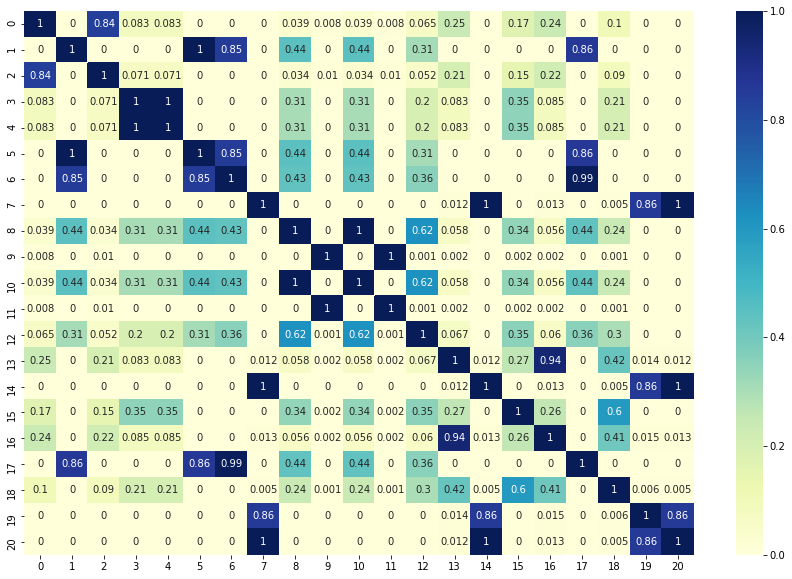

In [1025]:
jaccard_scores = antecedent_jaccard_scores(group_rules)
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(jaccard_scores,annot=True, ax=ax,cmap="YlGnBu")

Well, looks like there are some identical groups in there. 

In [1026]:
sim_group_ids = set()
jaccard_threshold = 0.8
for n1,row in enumerate(jaccard_scores):
    for n2,entry in enumerate(row):
        if entry >= jaccard_threshold and n1 != n2:
            sim_group_ids.add(frozenset([n1,n2]))
i = 0
sim_group_ids = list(sim_group_ids)
while i < len(sim_group_ids):
    changes = True
    while changes:
        changes = False
        for j in range(len(sim_group_ids) - 1, i, -1):
            if not sim_group_ids[i].isdisjoint(sim_group_ids[j]):
                changes = True
                sim_group_ids[i] |= sim_group_ids[j]
                del sim_group_ids[j]
    i += 1

In [1027]:
all_groups = list(range(len(ix)))
done_reps = []
best_representatives = []
for similar,iden in zip(sim_group_ids,ident):
    best_rep = -1
    for rep in similar:
        done_reps.append(rep)
        if best_rep == -1 or group_rules[rep]["lift"].median() > group_rules[best_rep]["lift"].median():
            best_rep = rep
    best_representatives.append(best_rep)
    print("The following groups have very similar antecedent sets (jaccard scores of > " + str(jaccard_threshold) + "):")
    for x in similar:
        print(x, revix[x])
    print("============================================================================================================")
for rep in done_reps:
    all_groups.remove(rep)
for rep in all_groups:
    best_representatives.append(rep)

The following groups have very similar antecedent sets (jaccard scores of > 0.8):
3 frozenset({'Ethnicity_White Majority', 'Education_Secondary School', 'Religion_Christian Majority'})
4 frozenset({'Ethnicity_White Majority', 'Education_Secondary School'})
The following groups have very similar antecedent sets (jaccard scores of > 0.8):
19 frozenset({'Ethnicity_Asian Majority'})
20 frozenset({'Income_Working Class', 'Ethnicity_Asian Majority'})
7 frozenset({'Ethnicity_Asian Majority', 'Education_Secondary School'})
14 frozenset({'Income_Working Class', 'Ethnicity_Asian Majority', 'Education_Secondary School'})
The following groups have very similar antecedent sets (jaccard scores of > 0.8):
17 frozenset({'Religion_Christian Majority', 'Education_Academic Degree'})
1 frozenset({'Education_Academic Degree', 'Ethnicity_White Majority'})
5 frozenset({'Religion_Christian Majority', 'Education_Academic Degree', 'Ethnicity_White Majority'})
6 frozenset({'Education_Academic Degree'})
The follo

In [1028]:
reduced_group_rules = []
ix = {}
revix = {}
for rep in best_representatives:
    name = group_rules[rep]["consequents"].iloc[0]
    ix[name] = len(reduced_group_rules)
    revix[len(reduced_group_rules)] = name
    newdf = group_rules[rep]
    newdf = newdf[newdf["lift"] >= 1.867]
    newdf = newdf[newdf["confidence"] >= 0.65]
    reduced_group_rules.append(newdf)

In [1029]:
reduced_filtered_group_rules = []
group_antecedents = []
for rules,ident in zip(reduced_group_rules,identifiers):
    antecedents = set()
    remove = set()
    for idx, row in rules.iterrows():
        antecedents.add(row["antecedents"])
    for x in antecedents:
        for y in antecedents:
            if not set_equals(x,y) and x.issubset(y):
                remove.add(x)
    for x in remove:
        antecedents.remove(x)
    group_antecedents.append(antecedents)
    newdf = rules.copy()
    newdf = newdf[newdf.apply(lambda x: True if x["antecedents"] in list(antecedents) else False, axis=1)]
    reduced_filtered_group_rules.append(newdf)

In [1030]:
rfgl_ls =  [reduced_filtered_group_rules[0][4:6],
            reduced_filtered_group_rules[1],
            reduced_filtered_group_rules[2][7:9],
            reduced_filtered_group_rules[4][23:25],
            reduced_filtered_group_rules[5],
            reduced_filtered_group_rules[6][3:5],
            reduced_filtered_group_rules[8][0:2]]

In [1036]:
nice_df = pd.concat(rfgl_ls)
nice_df["antecedents"] = nice_df.apply(lambda x: ''.join([label_processor(x).capitalize() + "<br>" for x in list(x["antecedents"])]).replace("_high", u" \u21D7").replace("_low", u" \u21D8") , axis = 1)
nice_df["consequents"] = nice_df.apply(lambda x: ''.join([label_processor(x).capitalize() + "<br>" for x in list(x["consequents"])]).replace("_high", u" \u21D7").replace("_low", u" \u21D8").replace("_", " "), axis = 1)
fig = ff.create_table(nice_df,height_constant=100)
path = "../fierceeagle.github.io/_includes/AssociationRuleTable_Nutrients.html"
fig.write_html(path)
plot_map_inline(path)